In [31]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

# -- References to Relevant Papers --
# [1] Pezzé & Smerzi, "Heisenberg-limited noisy atomic clock using a hybrid coherent and squeezed states protocol", Phys. Rev. A, 2020.
#     - Discusses the hybrid quantum-classical protocol for enhanced metrology using coherent and squeezed states.
#     - Relevant equations and concepts used in the time evolution and squeezing operations are found in Sections II and III of the paper. [41†source].
#
# [2] Hayes et al., "Making the most of time in quantum metrology: concurrent state preparation and sensing", Quantum Sci. Technol., 2018.
#     - Introduces the idea of accounting for preparation, sensing, and measurement times in metrology protocols.
#     - The concept of fixed total time and the trade-off between preparation, sensing, and measurement is covered on page 2. [42†source].
#
# [3] "Entanglement-enhanced quantum metrology: From standard quantum limit to Heisenberg limit" (Pezzé et al.), Rev. Mod. Phys., 2018.
#     - Describes Fisher Information, phase variance, and the use of entanglement to improve precision in quantum sensing.
#     - The scaling of Fisher Information with particle number and entanglement is introduced on page 6 of the paper. [42†source].
#



In [32]:
# Parameters for preparation, sensing, and measurement times
T_total = 1.0  # Total fixed time for the experiment

# Fraction of time allocated for preparation and measurement
tau_prep_fraction = 0.1  # Fraction of time spent on preparation
tau_meas_fraction = 0.05  # Fraction of time spent on measurement
tau_sense_fraction = 1 - tau_prep_fraction - tau_meas_fraction  # Remaining time for sensing

def generate_coherent_state(j):
    """
    Generate a coherent spin state aligned along the x-axis.

    Based on the description of coherent states for metrology in Pezzé & Smerzi, Section III. [41†source].
    
    Parameters:
        j (float): Total spin quantum number (N/2).
    
    Returns:
        Qobj: Coherent spin state.
    """
    theta = np.pi / 2  # Aligned along the x-axis
    phi = 0  # No rotation around the z-axis
    return qt.spin_coherent(j, theta, phi)

def apply_squeezing_operator(j, squeezing_strength, Jy):
    """
    Apply a squeezing operator to the coherent state.

    The use of squeezing to improve phase sensitivity is discussed in Hayes et al., Section 2.2. [42†source].
    
    Parameters:
        j (float): Total spin quantum number.
        squeezing_strength (float): The strength of squeezing.
        Jy (Qobj): Spin operator along the y-axis.
    
    Returns:
        Qobj: Squeezing operator.
    """
    squeezing_operator = (-1j * squeezing_strength * Jy**2).expm()
    return squeezing_operator

def time_evolve_state(H, state, t):
    """
    Perform time evolution of a quantum state under a Hamiltonian H for time t.

    Time evolution based on the Hamiltonian dynamics as outlined in Pezzé et al., Phys. Rev. A, 2020. Section II [41†source].
    
    Parameters:
        H (Qobj): Hamiltonian of the system.
        state (Qobj): Initial quantum state.
        t (float): Time of evolution.
    
    Returns:
        Qobj: Evolved quantum state after time t.
    """
    U = (-1j * H * t).expm()  # Time evolution operator U = exp(-i H t)
    return U * state

def measure_phase_variance(operator, state):
    """
    Measure the phase variance of the given state.

    Fisher Information and phase variance calculations are fundamental to quantum metrology, as discussed in Pezzé et al., Section III. [42†source].
    
    Parameters:
        operator (Qobj): Spin operator (typically Jz).
        state (Qobj): Quantum state (coherent or squeezed).
    
    Returns:
        float: Phase variance of the state.
    """
    return qt.variance(operator, state)

def calculate_fisher_information(N, sensing_time, is_entangled):
    """
    Calculate Fisher Information for both separable (SQL) and entangled (HL) states.

    This formula for Fisher Information scaling is adapted from Pezzé et al., Rev. Mod. Phys., 2018, page 6 [42†source].
    
    Parameters:
        N (int): Number of particles.
        sensing_time (float): The time spent in sensing.
        is_entangled (bool): If True, apply Heisenberg scaling for entangled states.
    
    Returns:
        float: Fisher Information.
    """
    if is_entangled:
        return N**2 * sensing_time**2  # Heisenberg scaling
    else:
        return N * sensing_time**2  # Standard Quantum Limit scaling

def calculate_r_value(F_sep, F_ent, total_time_sep, total_time_ent):
    """
    Calculate the metrological gain r, comparing separable and entangled strategies.

    This calculation is adapted from "Entanglement-enhanced quantum metrology", Section II. [42†source].
    
    Parameters:
        F_sep (float): Fisher Information for separable states.
        F_ent (float): Fisher Information for entangled states.
        total_time_sep (float): Total time for separable strategy.
        total_time_ent (float): Total time for entangled strategy.
    
    Returns:
        float: Metrological gain r.
    """
    return (F_ent / total_time_ent) / (F_sep / total_time_sep)



In [33]:
def calculate_phase_variances(N_max, omega, squeezing_strength, tau_prep_fraction, tau_meas_fraction, T_total):
    """
    Calculate phase variances and metrological gain r based on preparation, sensing, and measurement times.

    The trade-off between preparation, sensing, and measurement is described in Hayes et al., 2018 [42†source].
    
    Parameters:
        N_max (int): Maximum number of particles.
        omega (float): Frequency shift due to the local oscillator.
        squeezing_strength (float): Squeezing strength.
        tau_prep_fraction (float): Fraction of time for preparation.
        tau_meas_fraction (float): Fraction of time for measurement.
        T_total (float): Total fixed time.
    
    Returns:
        tuple: Phase variances for separable and entangled states, and metrological gain r.
    """
    phase_variance_sql = []
    phase_variance_hl = []
    r_values = []

    for N in range(1, N_max + 1):
        j = N / 2  # Total spin quantum number
        
        # Define collective spin operators
        Jy = qt.jmat(j, 'y')
        Jz = qt.jmat(j, 'z')

        # Allocate time based on total T_total
        tau_prep_sep = tau_prep_fraction * T_total
        tau_meas_sep = tau_meas_fraction * T_total
        tau_sense_sep = T_total - tau_prep_sep - tau_meas_sep

        tau_prep_ent = tau_prep_fraction * T_total
        tau_meas_ent = tau_meas_fraction * T_total
        tau_sense_ent = T_total - tau_prep_ent - tau_meas_ent

        # Separable (SQL) Strategy
        coherent_state = generate_coherent_state(j)
        H_sense = omega * Jz  # Sensing Hamiltonian
        evolved_coherent_state = time_evolve_state(H_sense, coherent_state, tau_sense_sep)
        phase_var_sql = measure_phase_variance(Jz, evolved_coherent_state)
        phase_variance_sql.append(phase_var_sql)

        # Entangled (HL) Strategy
        squeezing_operator = apply_squeezing_operator(j, squeezing_strength, Jy)
        squeezed_state = squeezing_operator * coherent_state
        evolved_squeezed_state = time_evolve_state(H_sense, squeezed_state, tau_sense_ent)
        phase_var_hl = measure_phase_variance(Jz, evolved_squeezed_state)
        phase_variance_hl.append(phase_var_hl)

        # Fisher Information
        F_sep = calculate_fisher_information(N, tau_sense_sep, is_entangled=False)
        F_ent = calculate_fisher_information(N, tau_sense_ent, is_entangled=True)

        # Calculate metrological gain r
        r_value = calculate_r_value(F_sep, F_ent, T_total, T_total)
        r_values.append(r_value)

    return np.array(phase_variance_sql), np.array(phase_variance_hl), np.array(r_values)




In [34]:
N_values = np.arange(1, N_max + 1)

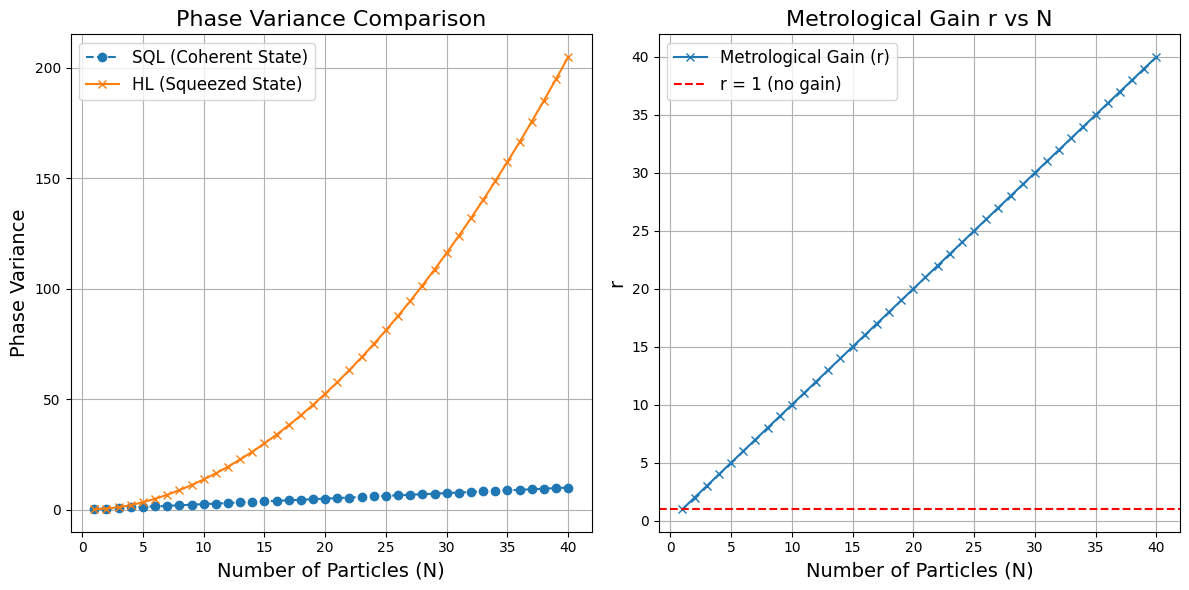

In [35]:
def plot_results(N_max, phase_variance_sql, phase_variance_hl, r_values):
    """
    Plot the phase variances and metrological gain r as a function of N.
    
    The scaling of phase variance and Fisher Information are discussed in Pezzé et al., Section III. [42†source].
    
    Parameters:
        N_max (int): Maximum number of particles.
        phase_variance_sql (np.array): Array of phase variances for SQL (Coherent State).
        phase_variance_hl (np.array): Array of phase variances for HL (Squeezed State).
        r_values (np.array): Array of metrological gain values.
    """
    plt.figure(figsize=(12, 6))

    # Plot phase variances
    plt.subplot(1, 2, 1)
    plt.plot(range(1, N_max+1), phase_variance_sql, label="SQL (Coherent State)", linestyle='--', marker='o')
    plt.plot(range(1, N_max+1), phase_variance_hl, label="HL (Squeezed State)", linestyle='-', marker='x')
    plt.title("Phase Variance Comparison", fontsize=16)
    plt.xlabel("Number of Particles (N)", fontsize=14)
    plt.ylabel("Phase Variance", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Plot metrological gain r
    plt.subplot(1, 2, 2)
    plt.plot(range(1, N_max+1), r_values, label="Metrological Gain (r)", linestyle='-', marker='x')
    plt.title("Metrological Gain r vs N", fontsize=16)
    plt.xlabel("Number of Particles (N)", fontsize=14)
    plt.ylabel("r", fontsize=14)
    plt.axhline(y=1, color='r', linestyle='--', label="r = 1 (no gain)")
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Parameters
N_max = 40
omega = 1.0
squeezing_strength = 0.5

# Calculate phase variances and r values
phase_variance_sql, phase_variance_hl, r_values = calculate_phase_variances(N_max, omega, squeezing_strength, tau_prep_fraction, tau_meas_fraction, T_total)

# Plot the results
plot_results(N_max, phase_variance_sql, phase_variance_hl, r_values)

In [36]:
# def find_Nopt_and_showcase(N_max, omega, squeezing_strength, tau_prep_fraction, tau_meas_fraction, T_total):
#     """
#     Find the optimal N (N_opt) where entanglement is no longer useful.
#     Plot results showing how entanglement loses its advantage beyond N_opt.
    
#     Parameters:
#         N_max (int): Maximum number of particles to consider.
#         omega (float): Frequency shift due to local oscillator.
#         squeezing_strength (float): The squeezing strength for HL strategy.
#         tau_prep_fraction (float): Fraction of total time spent in preparation.
#         tau_meas_fraction (float): Fraction of total time spent in measurement.
#         T_total (float): Total available time for the experiment (fixed).
#     """
    
#     # Calculate phase variances and r values for the given range of N
#     phase_variance_sql, phase_variance_hl, r_values = calculate_phase_variances(
#         N_max, omega, squeezing_strength, tau_prep_fraction, tau_meas_fraction, T_total
#     )
    
#     # Find N_opt where entanglement stops being useful (r drops below 1)
#     N_opt = None
#     for N in range(1, N_max + 1):
#         if r_values[N - 1] < 1:
#             N_opt = N
#             break
    
#     # Plot the results
#     plt.figure(figsize=(12, 6))

#     # Plot phase variances
#     plt.subplot(1, 2, 1)
#     plt.plot(range(1, N_max+1), phase_variance_sql, label="SQL (Coherent State)", linestyle='--', marker='o')
#     plt.plot(range(1, N_max+1), phase_variance_hl, label="HL (Squeezed State)", linestyle='-', marker='x')
#     plt.title("Phase Variance Comparison", fontsize=16)
#     plt.xlabel("Number of Particles (N)", fontsize=14)
#     plt.ylabel("Phase Variance", fontsize=14)
#     plt.axvline(x=N_opt, color='r', linestyle='--', label=f"N_opt = {N_opt}")
#     plt.legend(fontsize=12)
#     plt.grid(True)

#     # # Plot metrological gain r
#     # plt.subplot(1, 2, 2)
#     # plt.plot(range(1, N_max+1), r_values, label="Metrological Gain (r)", linestyle='-', marker='x')
#     # plt.title("Metrological Gain r vs N", fontsize=16)
#     # plt.xlabel("Number of Particles (N)", fontsize=14)
#     # plt.ylabel("r", fontsize=14)
#     # plt.axhline(y=1, color='r', linestyle='--', label="r = 1 (no gain)")
#     # plt.axvline(x=N_opt, color='r', linestyle='--', label=f"N_opt = {N_opt}")
#     # plt.legend(fontsize=12)
#     # plt.grid(True)

#     plt.tight_layout()
#     plt.show()

#     if N_opt:
#         print(f"The optimal number of particles (N_opt) where entanglement stops being useful is: {N_opt}")
#     else:
#         print("Entanglement is beneficial for all N up to N_max.")

# # Parameters
# N_max = 40
# omega = 1.0
# squeezing_strength = 0.5
# T_total = 1.0  # Total available time for experiment
# tau_prep_fraction = 0.5   # Fraction of time for preparation
# tau_meas_fraction = 0.05  # Fraction of time for readout

# # Find N_opt and showcase the results
# find_Nopt_and_showcase(N_max, omega, squeezing_strength, tau_prep_fraction, tau_meas_fraction, T_total)


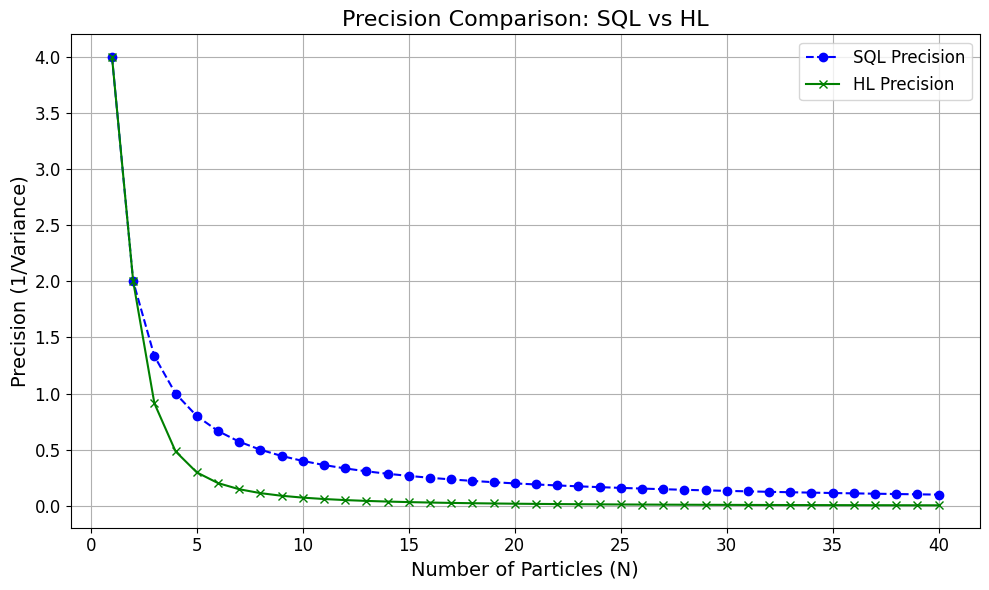

In [37]:
# Calculate precision as 1/variance
precision_sql = 1 / phase_variance_sql
precision_hl = 1 / phase_variance_hl

# Plot precision vs. N
plt.figure(figsize=(10, 6))
plt.plot(N_values, precision_sql, label="SQL Precision", linestyle='--', marker='o', color='blue')
plt.plot(N_values, precision_hl, label="HL Precision", linestyle='-', marker='x', color='green')

plt.title("Precision Comparison: SQL vs HL", fontsize=16)
plt.xlabel("Number of Particles (N)", fontsize=14)
plt.ylabel("Precision (1/Variance)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


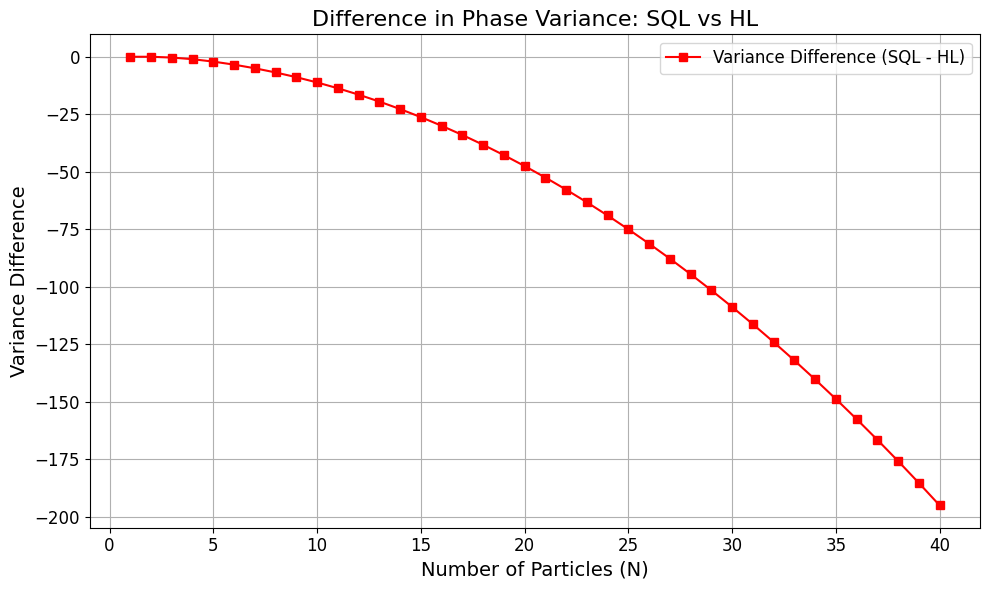

In [38]:
# Difference in variance (SQL - HL)
variance_diff = phase_variance_sql - phase_variance_hl

# Plot difference in variance
plt.figure(figsize=(10, 6))
plt.plot(N_values, variance_diff, label="Variance Difference (SQL - HL)", linestyle='-', marker='s', color='red')

plt.title("Difference in Phase Variance: SQL vs HL", fontsize=16)
plt.xlabel("Number of Particles (N)", fontsize=14)
plt.ylabel("Variance Difference", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


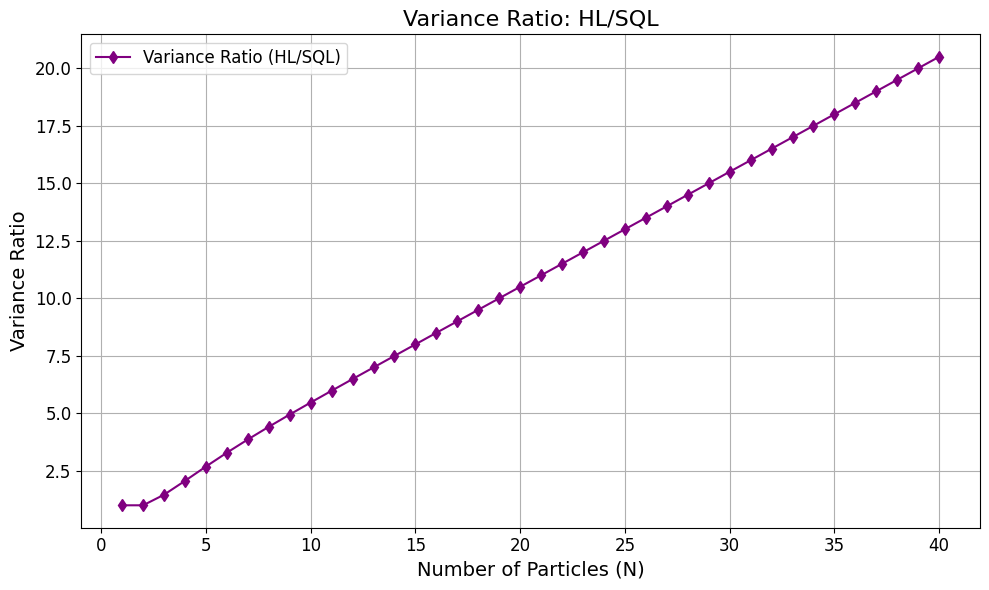

In [39]:
# Ratio of HL variance to SQL variance
variance_ratio = phase_variance_hl / phase_variance_sql

# Plot variance ratio
plt.figure(figsize=(10, 6))
plt.plot(N_values, variance_ratio, label="Variance Ratio (HL/SQL)", linestyle='-', marker='d', color='purple')

plt.title("Variance Ratio: HL/SQL", fontsize=16)
plt.xlabel("Number of Particles (N)", fontsize=14)
plt.ylabel("Variance Ratio", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


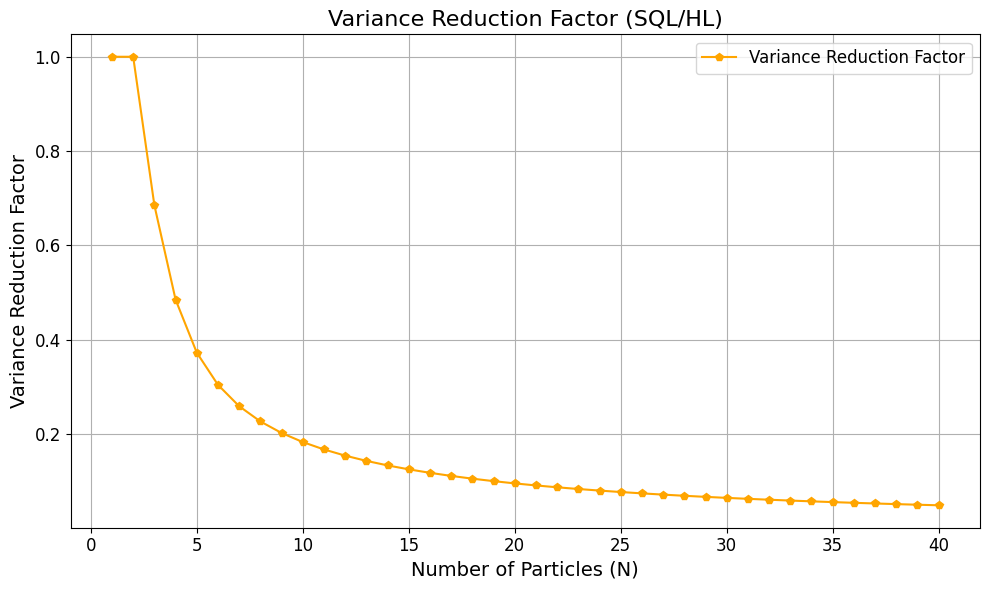

In [40]:
# Variance reduction factor: SQL variance / HL variance
variance_reduction_factor = phase_variance_sql / phase_variance_hl

# Plot variance reduction factor
plt.figure(figsize=(10, 6))
plt.plot(N_values, variance_reduction_factor, label="Variance Reduction Factor", linestyle='-', marker='p', color='orange')

plt.title("Variance Reduction Factor (SQL/HL)", fontsize=16)
plt.xlabel("Number of Particles (N)", fontsize=14)
plt.ylabel("Variance Reduction Factor", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
